In [148]:
from gensim.models import Word2Vec
import nltk
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import json
import os
import re
import preprocessor as p
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import sys
import pickle
from sklearn.metrics import silhouette_samples, silhouette_score

# Fetching Data Files

In [149]:
twitter_dest = "data/"
youtube_dest = "data/data_yt/"

In [150]:
twitter_all_files = os.listdir(twitter_dest)
youtube_all_files = os.listdir(youtube_dest)

In [151]:
keyword = 'imran khan'

twitter_files = []
youtube_files = []

for file in twitter_all_files:
    if keyword in file:
        twitter_files.append(file)
        
for file in youtube_all_files:
    if keyword in file:
        youtube_files.append(file)

In [152]:
# Loading Twitter JSON files

twitter_json = []

for file in twitter_files:
    with open(twitter_dest + file, encoding='utf-8') as json_file:
        
        # Load file
        data = json.load(json_file)
        
        # Concatenate all files
        twitter_json = twitter_json + data
        
twitter_json[0]

{'created_at': 'Sat Nov 30 23:52:15 +0000 2019',
 'id': 1200925541228064800,
 'id_str': '1200925541228064770',
 'full_text': 'RT @DunyaNews: PM Imran Khan lists down five strategies to cope with smog in Punjab and other parts of the country.\n\n#DunyaUpdates #DunyaNe…',
 'truncated': False,
 'display_text_range': [0, 140],
 'entities': {'hashtags': [{'text': 'DunyaUpdates', 'indices': [117, 130]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'DunyaNews',
    'name': 'Dunya News',
    'id': 99458922,
    'id_str': '99458922',
    'indices': [3, 13]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 916362400504451100,
  'id_str': '916362400504451072',
  'name': 'kami Khan',
  'scre

In [153]:
count = 0
dummy_tweets = []
for i in range( len(twitter_json) ):
    if twitter_json[i]['user']['followers_count'] > 50000:
        count += 1
        dummy_tweets.append(twitter_json[i]['full_text'])
        
count

91

In [154]:
# Loading YouTube JSON files

yt_json = []

for file in youtube_files:
    with open(youtube_dest + file, encoding='utf-8') as json_file:
        
        # Load file
        data = json.load(json_file)        
        
        # Concatenate all files
        yt_json = yt_json + data
    
yt_json[1]

{'kind': 'youtube#searchResult',
 'etag': '"j6xRRd8dTPVVptg711_CSPADRfg/MwmDdxLWE9HdLhei_XZaTs6py7g"',
 'id': {'kind': 'youtube#video', 'videoId': '8qRdFGilKA0'},
 'snippet': {'publishedAt': '2019-11-24T05:31:01.000Z',
  'channelId': 'UC_vt34wimdCzdkrzVejwX9g',
  'title': 'Pm Imran khan ne Aaj PTI Core Committee ijlas aaj talib kar liya',
  'description': 'Pm Imran khan ne Aaj core committee ijlas aaj talib kar liya For More Videos Subscribe - https://www.youtube.com/geonews Visit our Website for More Latest ...',
  'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/8qRdFGilKA0/default.jpg',
    'width': 120,
    'height': 90},
   'medium': {'url': 'https://i.ytimg.com/vi/8qRdFGilKA0/mqdefault.jpg',
    'width': 320,
    'height': 180},
   'high': {'url': 'https://i.ytimg.com/vi/8qRdFGilKA0/hqdefault.jpg',
    'width': 480,
    'height': 360}},
  'channelTitle': 'Geo News',
  'liveBroadcastContent': 'none'}}

In [155]:
# Retrieving relevant information from the Twitter JSON objects

columns = ['Created_time', 'URL', 'User_name', 'Twitter_handle', 'Description', 'Retweet_count', 'Favorite_count', 'Sentiment', 'Topic']
df_tweets = pd.DataFrame(columns=columns)

for i in range(0, len(twitter_json)):
    
    Created_time = twitter_json[i]['created_at']
    
    URL = 'twitter.com/i/web/status/' + twitter_json[i]['id_str']
    
    User_name = twitter_json[i]['user']['name']
    
    Twitter_handle = twitter_json[i]['user']['screen_name']
    
    if 'retweeted_status' not in twitter_json[i]:
        Description = twitter_json[i]['full_text']
    else:
        Description = twitter_json[i]['retweeted_status']['full_text']
    
    Retweet_count = twitter_json[i]['retweet_count']
    
    Favorite_count = twitter_json[i]['favorite_count']
    
    Sentiment = twitter_json[i]['sentiment']
    
    type = None
    if twitter_json[i]['user']['followers_count'] > 50000:
        type = 'News'
    else:
        type = 'Opinion'
    
    df_tweets = df_tweets.append({'Created_time':Created_time,'URL':URL,'User_name':User_name,
                                  'Twitter_handle':Twitter_handle,'Description':Description,
                                  'Retweet_count':Retweet_count,'Favorite_count':Favorite_count,
                                  'Sentiment':Sentiment, 'Topic':np.nan, 'Type':type}, ignore_index=True)
    
len(df_tweets)

5114

In [158]:
df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic,Type
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to co...,14,0,#ff0000,NaN,Opinion
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was...,0,1,#8caa0b,NaN,Opinion
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged ...,53,0,#8caa0b,NaN,Opinion
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imra...,0,0,#ff0000,NaN,Opinion
4,Sat Nov 30 23:49:18 +0000 2019,twitter.com/i/web/status/1200924799297568769,Muzaffar,chinar70,Deadly silence of the world on #Kashmir needs ...,0,0,#ff0000,NaN,Opinion


In [159]:
# Retrieving relevant information from the Youtube JSON objects

ss=r'([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))'
columns = ['Published_date', 'Title', 'URL', 'Channel_id', 'Topic']
df_videos = pd.DataFrame(columns=columns)

for i in range(0, len(yt_json)):
    
    Published_date = re.findall(ss,yt_json[i]['snippet']['publishedAt'])[0][0]
    
    Title = yt_json[i]['snippet']['title']
    
    Channel_id = yt_json[i]['snippet']['channelId']
    
    URL = 'https://www.youtube.com/watch?v=' + yt_json[i]['id']['videoId']
    
    df_videos = df_videos.append({'Published_date':Published_date,'Title':Title,
                                  'Channel_id':Channel_id,'URL':URL, 'Topic':np.nan}, ignore_index=True)

len(df_videos)

2450

In [160]:
df_videos.head()

,Published_date,Title,URL,Channel_id,Topic
0,2019-11-24,Norway Ka Waqia Islamophobia Ki Aik Taza Misaa...,https://www.youtube.com/watch?v=oUffbzy63DE,UC_vt34wimdCzdkrzVejwX9g,NaN
1,2019-11-24,Pm Imran khan ne Aaj PTI Core Committee ijlas ...,https://www.youtube.com/watch?v=8qRdFGilKA0,UC_vt34wimdCzdkrzVejwX9g,NaN
2,2019-11-24,PM Imran Khan to chair PTI core committee sess...,https://www.youtube.com/watch?v=fDhy5S0zfgA,UCMmpLL2ucRHAXbNHiCPyIyg,NaN
3,2019-11-24,Imran Khan makes Big Announcements,https://www.youtube.com/watch?v=XX47tVdjVIs,UCu5HXdNKsmWpfz5zeRCPXog,NaN
4,2019-11-24,PM Imran Khan announced his another mission | ...,https://www.youtube.com/watch?v=WMRBu6I8bbc,UC25Ntv5IrTD-B0eZ92O50Tg,NaN


In [161]:
# Added temporary column for processing 

df_tweets['cleaned'] = np.nan

df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic,Type,cleaned
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to co...,14,0,#ff0000,NaN,Opinion,NaN
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was...,0,1,#8caa0b,NaN,Opinion,NaN
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged ...,53,0,#8caa0b,NaN,Opinion,NaN
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imra...,0,0,#ff0000,NaN,Opinion,NaN
4,Sat Nov 30 23:49:18 +0000 2019,twitter.com/i/web/status/1200924799297568769,Muzaffar,chinar70,Deadly silence of the world on #Kashmir needs ...,0,0,#ff0000,NaN,Opinion,NaN


In [162]:
# Added temporary column for processing 

df_videos['cleaned'] = df_videos['Title']
df_videos.head()

,Published_date,Title,URL,Channel_id,Topic,cleaned
0,2019-11-24,Norway Ka Waqia Islamophobia Ki Aik Taza Misaa...,https://www.youtube.com/watch?v=oUffbzy63DE,UC_vt34wimdCzdkrzVejwX9g,NaN,Norway Ka Waqia Islamophobia Ki Aik Taza Misaa...
1,2019-11-24,Pm Imran khan ne Aaj PTI Core Committee ijlas ...,https://www.youtube.com/watch?v=8qRdFGilKA0,UC_vt34wimdCzdkrzVejwX9g,NaN,Pm Imran khan ne Aaj PTI Core Committee ijlas ...
2,2019-11-24,PM Imran Khan to chair PTI core committee sess...,https://www.youtube.com/watch?v=fDhy5S0zfgA,UCMmpLL2ucRHAXbNHiCPyIyg,NaN,PM Imran Khan to chair PTI core committee sess...
3,2019-11-24,Imran Khan makes Big Announcements,https://www.youtube.com/watch?v=XX47tVdjVIs,UCu5HXdNKsmWpfz5zeRCPXog,NaN,Imran Khan makes Big Announcements
4,2019-11-24,PM Imran Khan announced his another mission | ...,https://www.youtube.com/watch?v=WMRBu6I8bbc,UC25Ntv5IrTD-B0eZ92O50Tg,NaN,PM Imran Khan announced his another mission | ...


# Preprocessing Tweets

In [163]:
def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [164]:
# Set options to be removed
# Note: This may take a while.. Also, ignore the warning

#p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.HASHTAG)
p.set_options(p.OPT.URL, p.OPT.EMOJI)

for i in range(0, len(df_tweets)):
    
    # Clean URLs, Emojis, Hashtags
    df_tweets['cleaned'][i] = p.clean(df_tweets['Description'][i])
    
    # Remove '@' without removing the username
    df_tweets['cleaned'][i] = re.sub('@', ' ', df_tweets['cleaned'][i])
    
    # Remove '#' without removing the username
    df_tweets['cleaned'][i] = re.sub('#', ' ', df_tweets['cleaned'][i])
    
    #Remove all unicode(non-English) tweets
    x = df_tweets['cleaned'][i]
    x = x.replace('…','')
    x = x.replace('‘','')
    x = x.replace('’','')
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    x = emoji_pattern.sub(r'', x)        
    if isEnglish(x):
        df_tweets['cleaned'][i] = x
    else:
        df_tweets['cleaned'][i] = np.nan

D:\AnacondaIDE\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
D:\AnacondaIDE\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [165]:
df_tweets.head()

,Created_time,URL,User_name,Twitter_handle,Description,Retweet_count,Favorite_count,Sentiment,Topic,Type,cleaned
0,Sat Nov 30 23:52:15 +0000 2019,twitter.com/i/web/status/1200925541228064770,kami Khan,saleemkamikhan,PM Imran Khan lists down five strategies to co...,14,0,#ff0000,NaN,Opinion,PM Imran Khan lists down five strategies to co...
1,Sat Nov 30 23:52:03 +0000 2019,twitter.com/i/web/status/1200925489742974976,Irfan Ullah,IrfanUK11,@GulBukhari I just dont understand country was...,0,1,#8caa0b,NaN,Opinion,GulBukhari I just dont understand country was...
2,Sat Nov 30 23:51:07 +0000 2019,twitter.com/i/web/status/1200925253095972864,Sandy67,Sandy6704253501,#Pakistan Prime Minister #ImranKhan has urged ...,53,0,#8caa0b,NaN,Opinion,Pakistan Prime Minister ImranKhan has urged ...
3,Sat Nov 30 23:50:01 +0000 2019,twitter.com/i/web/status/1200924976511094786,Syyed Farrukh,FarrukhSyyed,Oyee kashmir per trend kerne walon \nOyee imra...,0,0,#ff0000,NaN,Opinion,Oyee kashmir per trend kerne walon Oyee imran ...
4,Sat Nov 30 23:49:18 +0000 2019,twitter.com/i/web/status/1200924799297568769,Muzaffar,chinar70,Deadly silence of the world on #Kashmir needs ...,0,0,#ff0000,NaN,Opinion,Deadly silence of the world on Kashmir needs ...


In [166]:
df_tweets.isnull().sum()

Created_time         0
URL                  0
User_name            0
Twitter_handle       0
Description          0
Retweet_count        0
Favorite_count       0
Sentiment            0
Topic             5114
Type                 0
cleaned            828
dtype: int64

In [167]:
df_tweets.dropna(subset=['cleaned'], inplace=True)

In [168]:
df_tweets.isnull().sum()

Created_time         0
URL                  0
User_name            0
Twitter_handle       0
Description          0
Retweet_count        0
Favorite_count       0
Sentiment            0
Topic             4286
Type                 0
cleaned              0
dtype: int64

In [169]:
# dropping ALL duplicte values 

df_tweets.drop_duplicates(subset ="Description", 
                     keep = 'first', inplace = True)

# Reset index
df_tweets = df_tweets.reset_index(drop=True)

len(df_tweets)

2553

In [170]:
# function to plot most frequent terms

def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

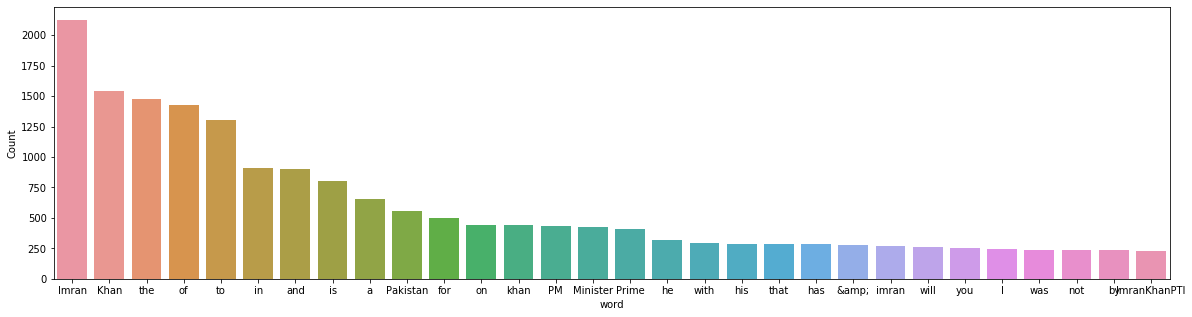

In [171]:
freq_words(df_tweets['cleaned'])

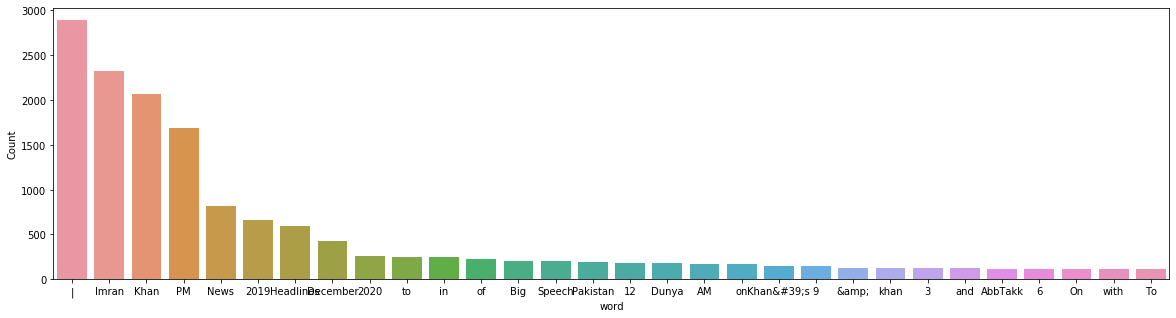

In [172]:
freq_words(df_videos['Title'])

In [173]:
# remove unwanted characters, numbers and symbols

df_tweets['cleaned'] = df_tweets['cleaned'].str.replace("[^a-zA-Z]", " ")
df_tweets['cleaned'] = df_tweets['cleaned'].str.replace('&amp;', " ")
df_tweets['cleaned'] = df_tweets['cleaned'].str.replace('amp', " ")

df_videos['cleaned'] = df_videos['cleaned'].str.replace("[^a-zA-Z]", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("SAMAA TV", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("BBC", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("Dunya", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("News", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("Headlines", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("&amp;", " ")
df_videos['cleaned'] = df_videos['cleaned'].str.replace("amp", " ")

In [174]:
# remove all Roman Urdu words

words = set(nltk.corpus.words.words())

for i in range(0, len(df_tweets)):
    text = df_tweets['cleaned'][i]
    cleaned = ""
    for w in nltk.wordpunct_tokenize(text):
        if w.lower() in words and w.isalpha():
            cleaned = cleaned + w + ' '
    df_tweets['cleaned'][i] = cleaned

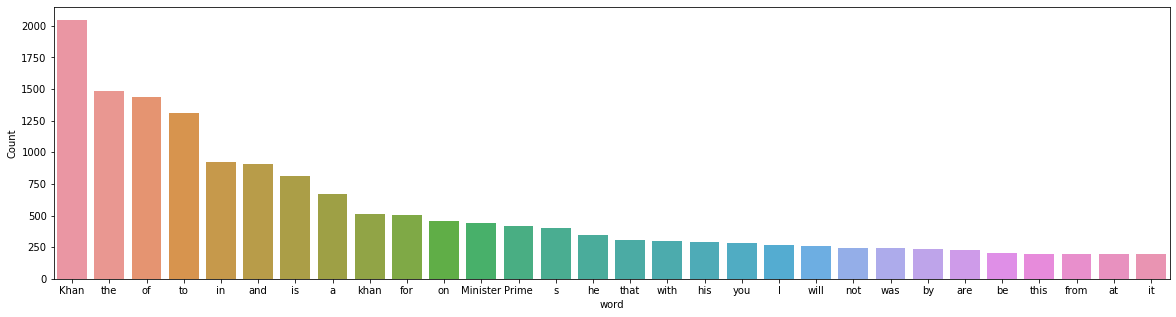

In [175]:
freq_words(df_tweets['cleaned'])

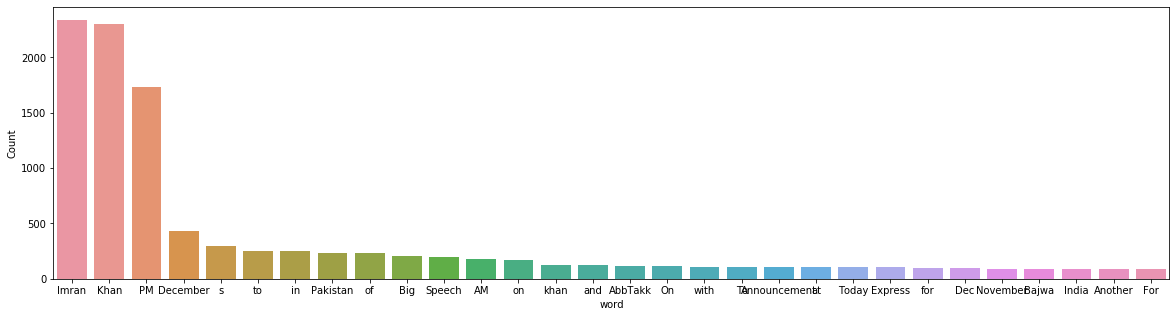

In [176]:
freq_words(df_videos['cleaned'])

In [177]:
# Remove short tweets

i = 0
l = len(df_tweets)
while i < l:
    w = df_tweets['Description'][i].split()
    if len(w) <= 3:
        df_tweets = df_tweets.drop(df_tweets.index[i])
        df_tweets = df_tweets.reset_index(drop=True)
    i = i + 1
    l = len(df_tweets)

len(df_tweets)

2528

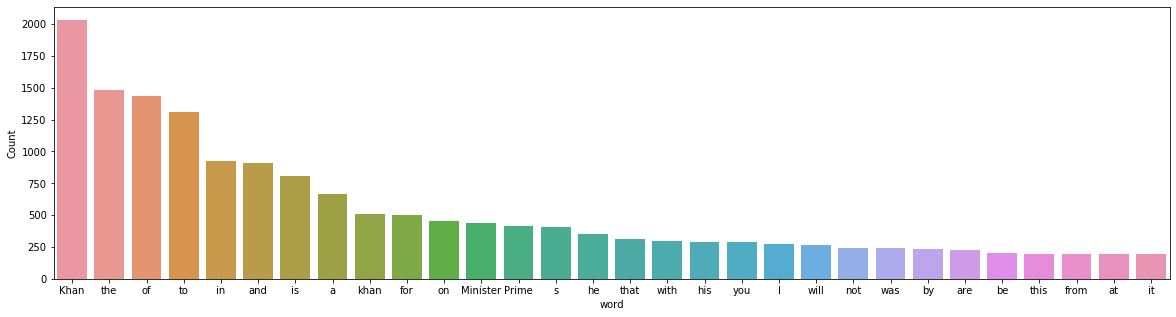

In [178]:
freq_words(df_tweets['cleaned'])

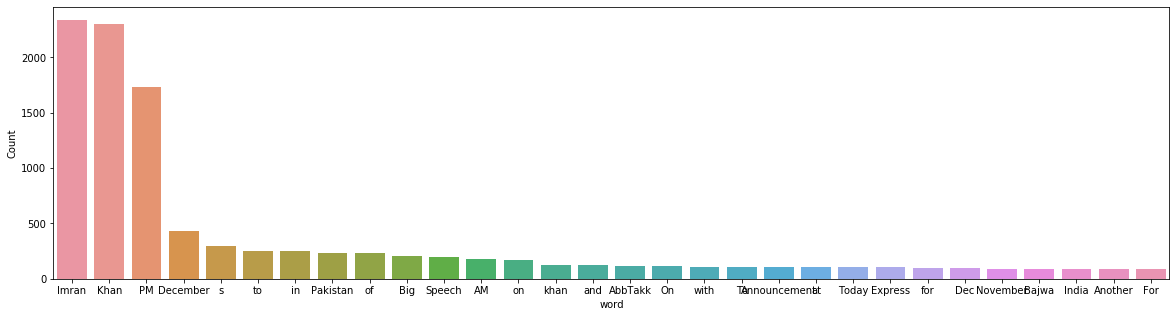

In [179]:
freq_words(df_videos['cleaned'])

# Text Preprocessing

In [180]:
stop_words = stopwords.words('english')

In [181]:
# function to remove stopwords

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [182]:
# remove short words (length < 3)

df_tweets['cleaned'] = df_tweets['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

df_videos['cleaned'] = df_videos['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [183]:
# remove stopwords from the text

tweets = [remove_stopwords(r.split()) for r in df_tweets['cleaned']]

videos = [remove_stopwords(r.split()) for r in df_videos['cleaned']]

In [184]:
# Convert letters into lower case

tweets = [r.lower() for r in tweets]

videos = [r.lower() for r in videos]

In [185]:
#tweets = [r.replace("imran", " ") for r in tweets]
#tweets = [r.replace("khan", " ") for r in tweets]
for word in keyword.split():
    tweets = [r.replace(word, " ") for r in tweets]
    videos = [r.replace(word, " ") for r in videos]

In [186]:
for word in keyword.split():
    videos = [r.replace(word, " ") for r in videos]

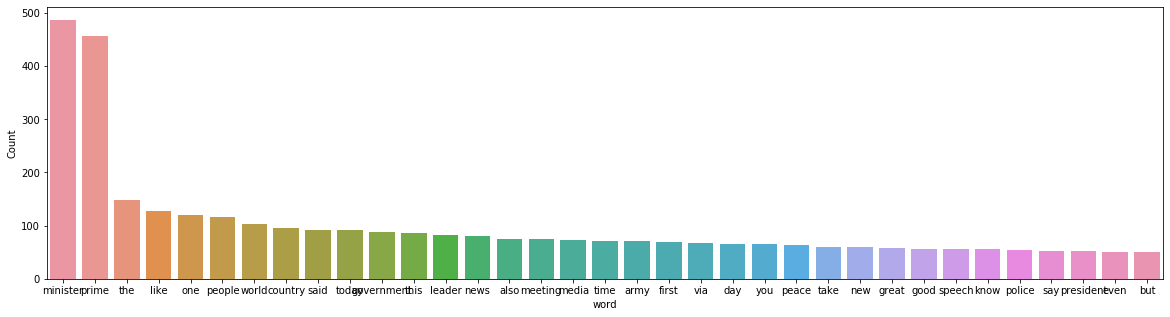

In [187]:
freq_words(tweets, 35)

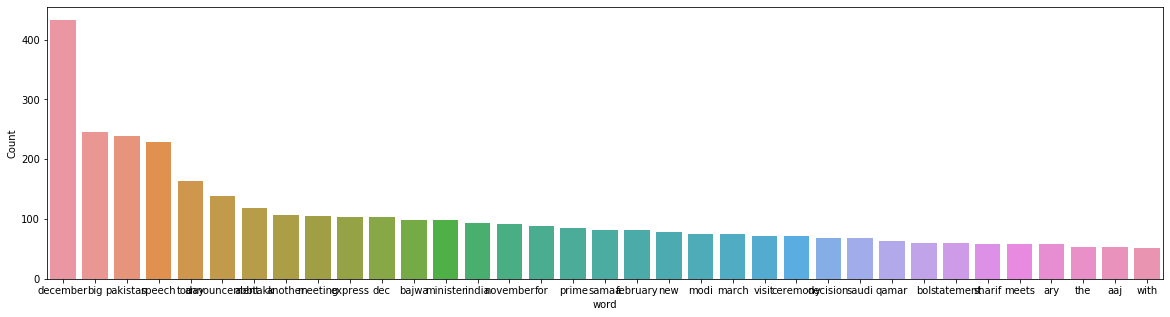

In [188]:
freq_words(videos, 35)

In [189]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        result.append(lemmatize_stemming(token))            
    return result

In [190]:
# Temporary dataframe for mapping lemmatized texts

tweets_1 = pd.DataFrame(tweets, columns=['text'])

videos_1 = pd.DataFrame(videos, columns=['title'])

In [191]:
# Extracting lemmatized words

processed_tweets = tweets_1['text'].map(preprocess)

processed_videos = videos_1['title'].map(preprocess)

In [192]:
processed_tweets.head()

0                          [five, cope, smog, countri]
1    [dont, understand, countri, suffer, sever, cor...
2    [prime, minist, world, help, end, curfew, ther...
3                      [per, trend, number, rape, hey]
4                    [dead, silenc, world, need, long]
Name: text, dtype: object

In [193]:
processed_videos.head()

0    [norway, waqia, islamophobia, aik, taza, misaa...
1    [aaj, pti, core, committe, ijla, aaj, talib, k...
2         [chair, pti, core, committe, session, today]
3                                 [make, big, announc]
4             [announc, anoth, mission, novemb, samaa]
Name: title, dtype: object

In [194]:
# For tokenizing words from tweets

tokenized_tweets = []
for tweet in processed_tweets:
    tokenized_tweets.append(tweet)

tokenized_tweets[0]

['five', 'cope', 'smog', 'countri']

In [195]:
# For tokenizing words from videos

tokenized_videos = []
for video in processed_videos:
    tokenized_videos.append(video)
    
tokenized_videos[0]

['norway', 'waqia', 'islamophobia', 'aik', 'taza', 'misaal', 'hey']

# Creating the Word2Vec model

In [196]:
model = Word2Vec(tokenized_tweets, size=2, min_count=1)

def vectorizer(sent, m):
    vec = []
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                vec = m[w]
            else:
                vec = np.add(vec, m[w])
            numw += 1
        except:
            pass
    
    return np.asarray(vec, dtype=np.float) / numw

l = []

for i in tokenized_tweets:
    l.append(vectorizer(i, model))    

#X = model[model.wv.vocab]
X = np.array(l)

D:\AnacondaIDE\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
D:\AnacondaIDE\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


# KMeans Clustering

In [197]:
for i in range(len(X)):
    if len(X[i]) == 0:
        X[i] = np.nan
len(X)

2528

In [198]:
output = []
tokenized_tweets_new = []
i = 0
for elem in X:
    if elem is not np.nan:
        output.append(elem)
        tokenized_tweets_new.append(tokenized_tweets[i])
    else:
        #df_tweets = df_tweets.drop(df_tweets.index[i])
        df_tweets = df_tweets.drop([i])
    i += 1

df_tweets = df_tweets.reset_index(drop=True)
X = np.array(output)
tokenized_tweets = tokenized_tweets_new
len(X)

2453

In [199]:
# Training models with different no. of clusters

wccs = []
no_of_clusters = [10, 15, 20, 25, 30, 35, 40]
for i in no_of_clusters:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wccs.append(kmeans.inertia_)

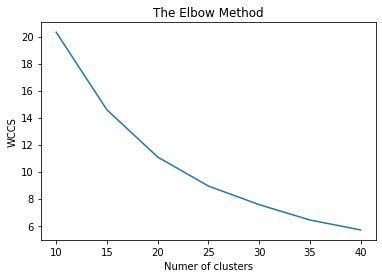

In [200]:
# Select best no. of clusters

plt.plot(no_of_clusters, wccs)
plt.title('The Elbow Method')
plt.xlabel('Numer of clusters')
plt.ylabel('WCCS')
plt.show()

For n_clusters = 10 The average silhouette_score is : 0.33522416218792866
For n_clusters = 15 The average silhouette_score is : 0.3185525736871156
For n_clusters = 20 The average silhouette_score is : 0.31880748094455863
For n_clusters = 25 The average silhouette_score is : 0.327449735267958
For n_clusters = 30 The average silhouette_score is : 0.33143764859939234
For n_clusters = 35 The average silhouette_score is : 0.3248597834786896


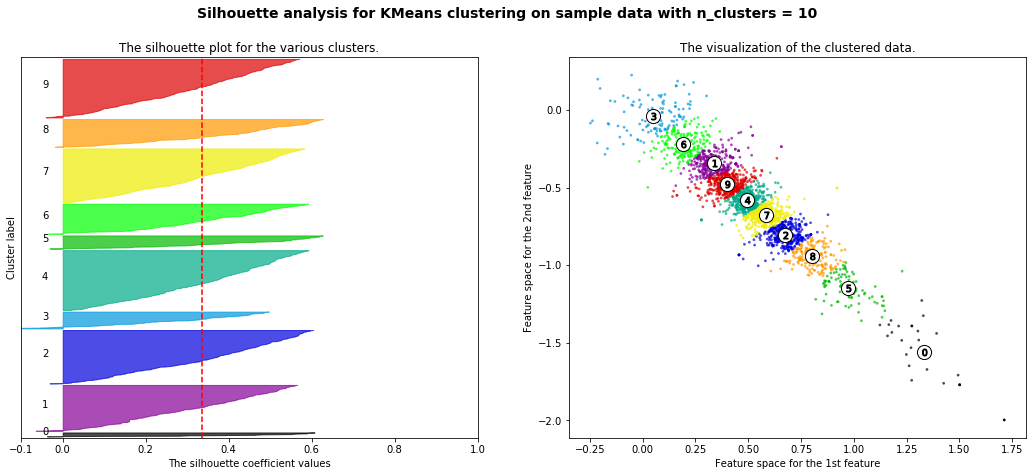

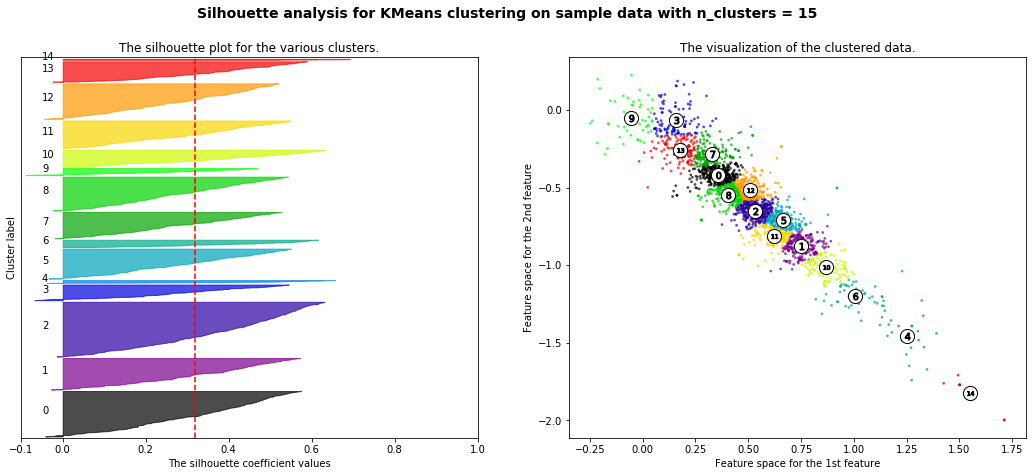

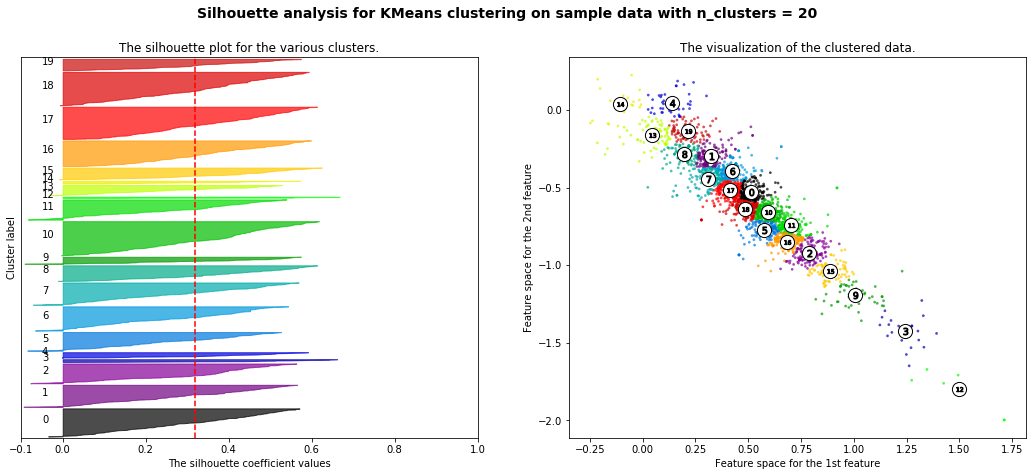

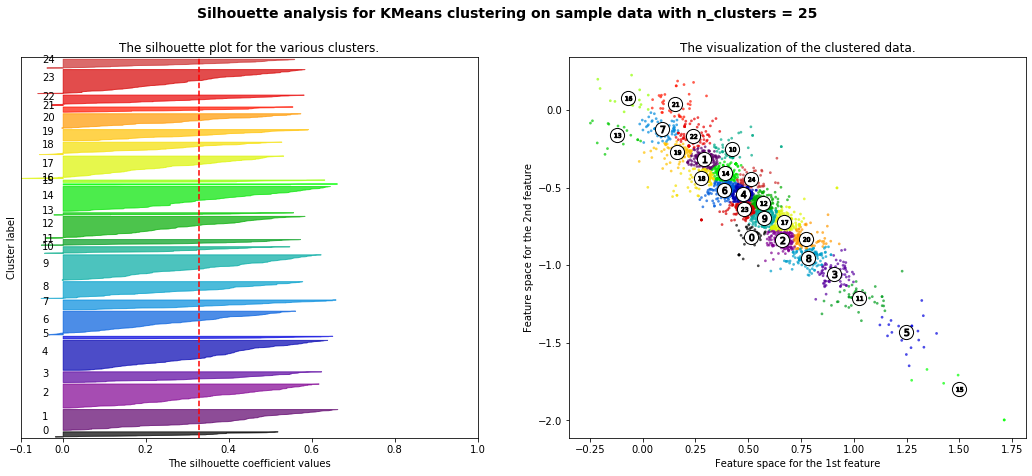

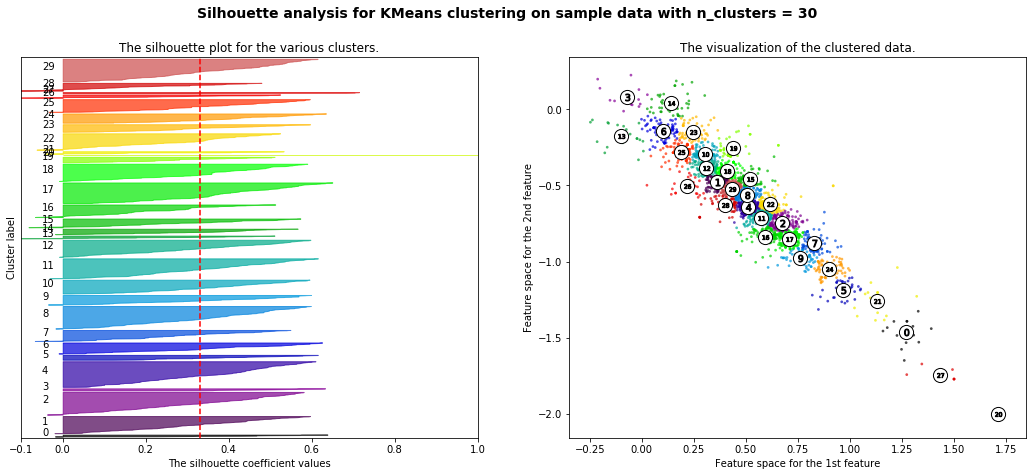

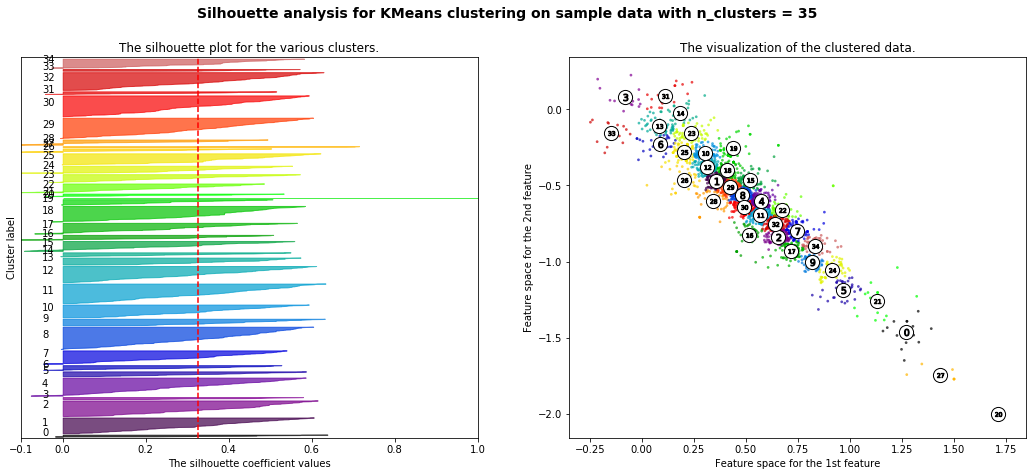

In [201]:
# Using Silhoutte Analysis to find optimum number of clusters

import matplotlib.pyplot as plt
import matplotlib.cm as cm

max_score = 0
max_number = 0

no_of_clusters = [10, 15, 20, 25, 30, 35]
for n_clusters in no_of_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    if silhouette_avg > max_score:
        max_score = silhouette_avg
        max_number = n_clusters

plt.show()

In [202]:
n_clusters = 10
#n_clusters = max_number
clf = KMeans(n_clusters = n_clusters, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X)

In [205]:
# For tweets:

i = 0
for index, sentence in enumerate(tokenized_tweets):
    
    df_tweets['Topic'][i] = int(labels[index])
    
    i += 1

In [ ]:
df_tweets.head()

In [ ]:
##### Clustering videos and assigning topics to videos

model = Word2Vec(tokenized_videos, size=2, min_count=1)
l = []
for i in tokenized_videos:
    l.append(vectorizer(i, model))
X = np.array(l)

for i in range(len(X)):
    if len(X[i]) == 0:
        X[i] = np.nan

output = []
tokenized_videos_new = []
i = 0
for elem in X:
    if elem is not np.nan:
        output.append(elem)
        tokenized_videos_new.append(tokenized_videos[i])
    else:
        df_videos = df_videos.drop(df_videos.index[i])
    i += 1

df_videos = df_videos.reset_index(drop=True)
X = np.array(output)
tokenized_videos = tokenized_videos_new

labels = clf.predict(X)

i = 0
for index, sentence in enumerate(tokenized_videos):

    df_videos['Topic'][i] = int(labels[index])

    i += 1

In [225]:
from gensim import corpora
# We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

dictionary = corpora.Dictionary(tokenized_videos)

# Then we will convert the list of texts into a Document Term Matrix using the dictionary prepared above.

doc_term_matrix = [dictionary.doc2bow(text) for text in tokenized_videos]

LDA = gensim.models.ldamodel.LdaModel

# Training the model on 2 topics

num_of_topics = 10

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_of_topics, random_state=100,
                chunksize=1000, passes=50)

corpus = [dictionary.doc2bow(text) for text in tokenized_videos]
for i in range(0, len(df_videos)):
    
    doc = corpus[i]
    
    # This contains probability of tweet assigned to each topic
    vector = lda_model[doc]
    
    # Getting the topic that has maximum probability
    max_res = 0
    
    for res in vector:
        if (res[1] > max_res):
            max_res = res[1]
            ind = res[0]
            
    df_videos['Topic'][i] = int(np.int32(ind))

In [226]:
df_videos.head()

,Published_date,Title,URL,Channel_id,Topic,cleaned
0,2019-11-24,Norway Ka Waqia Islamophobia Ki Aik Taza Misaa...,https://www.youtube.com/watch?v=oUffbzy63DE,UC_vt34wimdCzdkrzVejwX9g,6,Norway Waqia Islamophobia Aik Taza Misaal Hey ...
1,2019-11-24,Pm Imran khan ne Aaj PTI Core Committee ijlas ...,https://www.youtube.com/watch?v=8qRdFGilKA0,UC_vt34wimdCzdkrzVejwX9g,0,Imran khan Aaj PTI Core Committee ijlas aaj ta...
2,2019-11-24,PM Imran Khan to chair PTI core committee sess...,https://www.youtube.com/watch?v=fDhy5S0zfgA,UCMmpLL2ucRHAXbNHiCPyIyg,0,Imran Khan chair PTI core committee session today
3,2019-11-24,Imran Khan makes Big Announcements,https://www.youtube.com/watch?v=XX47tVdjVIs,UCu5HXdNKsmWpfz5zeRCPXog,7,Imran Khan makes Big Announcements
4,2019-11-24,PM Imran Khan announced his another mission | ...,https://www.youtube.com/watch?v=WMRBu6I8bbc,UC25Ntv5IrTD-B0eZ92O50Tg,7,Imran Khan announced his another mission Novem...


In [228]:
###### Drop the temporary columns

df_tweets = df_tweets.drop(['cleaned'], axis=1)
df_videos = df_videos.drop(['cleaned'], axis=1)

In [229]:
##### Export twitter data to json format for further processing

df_to_json_tweets = df_tweets.to_dict('records')
file = r'model\topic-tweets_' + keyword + '_' + str(n_clusters) + '_topics.json'
with open(file, 'w', encoding='utf-8') as outfile:
    json.dump(df_to_json_tweets, outfile)

##### Export youtube data to json format for further processing

df_to_json_videos = df_videos.to_dict('records')
file = r'model\topic-videos_' + keyword + '_' + str(n_clusters) + '_topics.json'
with open(file, 'w', encoding='utf-8') as outfile:
    json.dump(df_to_json_videos, outfile)

In [128]:
##### Saving model

filename = 'cluster/kmeans-'+keyword+'.sav'
pickle.dump(clf, open(filename, 'wb'))